In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install Packages required for the project
!pip install transformers
!pip3 install librosa
!pip3 install matplotlib
!pip3 install pandas
!pip3 install sklearn
!pip3 install tensorflow
!pip install stanza
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Importing the required libraries
%matplotlib inline

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import stanza
import re
import librosa
import sklearn
sklearn.__version__
from sklearn.utils import class_weight
from sklearn import model_selection, preprocessing, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import neighbors
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
import numpy as np
import random
random.seed(60)
import cv2 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import np_utils
import time
# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import string
import fasttext
from tqdm import tqdm

# ---- Call tqdm to see progress bar with pandas
tqdm().pandas()

0it [00:00, ?it/s]


In [5]:
Features = np.load('/content/drive/MyDrive/Mini Project/Dataset/Audio/Audio_features.npy')
Y_data = np.load('/content/drive/MyDrive/Mini Project/Dataset/Audio/Audio_label.npy')
len(Features), len(Y_data)

(88, 88)

In [6]:
Features_OpenS = np.load('/content/drive/MyDrive/Mini Project/Dataset/Audio/Audio_Opensmile_X.npy')
Y_OpenS = np.load('/content/drive/MyDrive/Mini Project/Dataset/Audio/Audio_Opensmile_Y.npy')
Features_OpenS.shape, Y_OpenS.shape

((88, 6373), (88,))

**Text Data loading and Pre process**

In [7]:
def load_text(path, n, label):
  x = []
  for i in range(n):
    T = ""
    with open(str(path + str(i+1)+'.txt')) as f:
      lines = f.readlines()
      for e in lines:
        T = T + e
    x.append(T)
  L = np.zeros(len(x))
  if(label == 1):
    L = np.ones(len(x))
  return x, L

In [8]:
p = ['/content/drive/MyDrive/Mini Project/Dataset/Text/Abusive/Abusive-',
     '/content/drive/MyDrive/Mini Project/Dataset/Text/Non Abusive/Non-Abusive-']
N = [47, 41]
L = [1, 0]
Text_nab, Lbl_nab = load_text(p[0] ,N[0], L[0])
Text_ab, Lbl_ab = load_text(p[1], N[1], L[1])

In [9]:
Text = Text_nab + Text_ab
Lbl = np.concatenate((Lbl_nab, Lbl_ab), axis = 0)
len(Text), len(Lbl)

(88, 88)

In [10]:
df = pd.DataFrame(data=[Text, Lbl], index=["text", "label"]).T
df

,text,label
0,அஞ்சு வருஷம் உங்க பவர் காமிச்சீங்களே என்ன ஆட்ட...,1.0
1,நரேந்திர மோடியா நீதிபதியா வந்து நரேந்திர மோடிக...,1.0
2,ஒன்னும் தெரியாத மண்ணு கூதியே எடப்பாடி பழனி சம்...,1.0
3,அதே மாதிரி இந்த பொண்ணுங்களம் வந்து கலை நான் உன...,1.0
4,இதுல வந்து என்னப்பதி தப்ப பேசுறது இதெல்லாம் வெ...,1.0
...,...,...
83,நா இந்த வீடியோ ல சாதாரண ஆளுங்களுக்கா க பேசலைங்...,0.0
84,சார் மூணு மாசத்துக்கு அப்புறம் தா ந இருப்பது ஒ...,0.0
85,வாழ்க்கைல சொத்து சுகம் பிகுர் இப்படி எதைவேனாலு...,0.0
86,நிகழ்ச்சிக்கு வந்து ருக்கூம். வணக்கம் உங்க பெர...,0.0


In [11]:
class PreProcessing(object):
    '''
    Class to preprocess text
    
    '''
    
    
    def __init__(self):
        #print("Welcome in the preprocessing")
        pass
    
    @classmethod    
    def detect_lang_google(self, x):
        '''
        Function to detect the language of the string
        @param x: (str) sentences of text to detect language
        @return: (str or nan) language of the sentence
        '''
        translate = Translator()
        try:
            return translate.detect(x).lang
        except:
            return np.nan
    
    @classmethod
    def remove_numbers(self, text):
        '''
        Function to remove number in text.
        @param text: (str) sentence
        @return: (str) clean text
        '''
        text = ''.join([i for i in text if not i.isdigit()])         
        return text
    
    @classmethod
    def remove_URL(self, text):
        '''
        Function to remove url from text.
        @param text: (str) sentence
        @return: (str) clean text
        
        '''
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)
    
    @classmethod
    def remove_html(self, text):
        '''
        Function regex to clean text from html balises.
        @param text: (str) sentence 
        @return: (str) clean text 
        '''
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)
    
    
    @classmethod
    def remove_emoji(self, text):
        '''
        Function to remove emojis, symbols and pictograms etc from text
        @param text: (str) sentences 
        @return: (str) clean text 
        '''
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    
    
    @classmethod
    def preprocess(self, text):
        '''
        Function to remove special characters
        @param text: (pandas dataframe) text
        @return: (pandas dataframe) clean text 
        '''
        text = text.replace("(<br/>)", "")
        text = text.replace('(<a).*(>).*(</a>)', '')
        text = text.replace('(&amp)', '')
        text = text.replace('(&gt)', '')
        text = text.replace('(&lt)', '')
        text = text.replace('(\xa0)', ' ')  
        text = text.replace("\n", " ")
        text = text.replace("\x92", "'")
        return text
    
    @classmethod
    def remove_char_specific(self, text):
        '''
        Function to remove specific characters
        @param text: (str) text
        @return: (str) text without specific characters
        '''
        table = '!"#$%&()*+,./:;<=>?@[\]^_`{|}~•'
        table = str.maketrans(' ', ' ', table)
        words = text.split()
        stripped = [w.translate(table) for w in words]
        return ' '.join(stripped)
    
    @classmethod
    def remove_upper_case(self, text):
        '''
        Function to transform upper string in title words
        @param text: (str) text 
        @return: (str) text without upper words 
        '''
        words = text.split()
        stripped = [w.title() if w.isupper() else w for w in words]
        return " ".join(stripped)
    
    @classmethod
    def remove_stop_words(self, x, stop_word):
        '''
        Function to remove a list of words
        @param x : (str) text 
        @param stop_word: (list) list of stopwords to delete 
        @return: (str) new string without stopwords 
        '''
        x_new = text_to_word_sequence(x)    # tokenize text 
        x_ = []
        for i in x_new:
            if i not in stop_word:
                x_.append(i)
        return " ".join(x_)
    
    @classmethod
    def get_top_n_words(self, corpus, n=None):
        '''
        Function to return a list of most frequent unigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        vec = CountVectorizer().fit(corpus)             # bag of words
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)  
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]
    
    @classmethod
    def get_top_n_words_sw(self, corpus, stop_word=None, lang="fr", n=None):
        '''
        Function to return a list of most frequent unigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param stop_word: (list) list containing stopwords
        @param lang: (str) language of the text
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        if lang=="fr":
            corpus = corpus.apply(lambda x: self.remove_stop_words(x, stop_word))
        vec = CountVectorizer(stop_words = "english").fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]
    
    @classmethod
    def get_top_n_bigram(self, corpus, n=None):
        '''
        Function to return a list of most frequent bigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus) 
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]
    
    @classmethod
    def get_top_n_bigram_sw(self, corpus, stop_word=None, lang="fr", n=None):
        '''
        Function to return a list of most frequent bigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param stop_word: (list) list containing stopwords
        @param lang: (str) language of the text
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        if lang=="fr":
            corpus = corpus.apply(lambda x: self.remove_stop_words(x, stop_word))
        vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]
    
    @classmethod
    def get_top_n_trigram(self, corpus, n=None):
        '''
        Function to return a list of most frequent trigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]

    @classmethod
    def get_top_n_trigram_sw(self, corpus, stop_word=None, lang="fr", n=None):
        '''
        Function to return a list of most frequent trigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param stop_word: (list) list containing stopwords
        @param lang: (str) language of the text
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        if lang=="fr":
            corpus = corpus.apply(lambda x: self.remove_stop_words(x, stop_word))
        vec = CountVectorizer(ngram_range=(3, 3), stop_words="english").fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]
    
    @classmethod
    def get_top_n_5grams_sw(self, corpus, stop_word=None, lang="fr", n=None):
        '''
        Function to return a list of most frequent trigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param stop_word: (list) list containing stopwords
        @param lang: (str) language of the text
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        if lang=="fr":
            corpus = corpus.apply(lambda x: self.remove_stop_words(x, stop_word))
        vec = CountVectorizer(ngram_range=(5, 5), stop_words="english").fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]

In [12]:
preproc = PreProcessing()
df["text"] = df["text"].progress_apply(preproc.remove_URL)
df["text"] = df["text"].progress_apply(preproc.remove_html)
df["text"] = df["text"].progress_apply(preproc.remove_emoji)
# ---- Extract statistics of the text 
df['char_count'] = df["text"].apply(len) # Number of characters in the string
df['word_count'] = df["text"].apply(lambda x: len(x.split())) # Number of words in the string 
df['word_density'] = df['char_count'] / (df['word_count']+1) # Density of word (in char)
df['punctuation_count'] = df["text"].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df["text"].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()])) # Number of words containing upper letter in first place 
df['upper_case_word_count'] = df["text"].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
from keras.preprocessing.text import text_to_word_sequence
df.loc[:,"text_sw"] = df.loc[:,"text"].progress_apply(lambda x : preproc.remove_stop_words(x, "/"))
if df["text_sw"].isnull().sum()>0:
    print("Empty text")
    df["text_sw"][df["text_sw"].isnull()] = "empty_text"

100%|██████████| 88/88 [00:00<00:00, 8369.59it/s]


In [13]:
'''
Test_ind = random.sample(range(0, len(Text)), 17)
Test_ind

Output Received:
[30, 69, 35, 8, 28, 16, 32, 26, 25, 74, 82, 15, 64, 40, 63, 46, 48, 11]
'''
Test_ind = [30, 69, 35, 8, 28, 16, 32, 26, 25, 74, 82, 15, 64, 40, 63, 46, 48, 11]

**Video Frames**

In [14]:
xvid_pad_train = np.load('/content/drive/MyDrive/Mini Project/Dataset/Video/Vid_Pad_Train.npy')
xvid_pad_test = np.load('/content/drive/MyDrive/Mini Project/Dataset/Video/Vid_Pad_Test.npy')
yvid_train = np.load('/content/drive/MyDrive/Mini Project/Dataset/Video/Vid_Pad_Train_lbls.npy')
yvid_test = np.load('/content/drive/MyDrive/Mini Project/Dataset/Video/Vid_Pad_Test_lbls.npy')

In [15]:
# ML classic 
train_x_sw = []
train_x = []
test_x_sw = []
test_x = []
train_y_sw = []
test_y_sw = []
train_y = []
test_y = []
Aud_train = []
Aud_test = []
Aud_train_OpenS = []
Aud_test_OpenS = []
for i in range(0, len(Text)):
  if(i not in Test_ind):
    train_x_sw.append(df.loc[i, "text_sw"])
    train_x.append(df.loc[i,"text"])
    train_y.append(df.loc[i,"label"])
    train_y_sw.append(df.loc[i,"label"])
    Aud_train.append(Features[i])
    Aud_train_OpenS.append(Features_OpenS[i])
  else:
    Aud_test.append(Features[i])
    Aud_test_OpenS.append(Features_OpenS[i])
    test_x_sw.append(df.loc[i,"text_sw"])
    test_x.append(df.loc[i,"text"])
    test_y.append(df.loc[i,"label"])
    test_y_sw.append(df.loc[i,"label"])

In [16]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df["text"])
xtrain_tfidf =  tfidf_vect.transform(train_x_sw)
xtest_tfidf =  tfidf_vect.transform(test_x_sw)
print("word level tf-idf done")
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df["text"])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x_sw)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(test_x_sw)
print("ngram level tf-idf done")
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',  ngram_range=(2,3), max_features=5000) 
tfidf_vect_ngram_chars.fit(df["text"])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x_sw) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(test_x_sw) 
print("characters level tf-idf done")

word level tf-idf done
ngram level tf-idf done
characters level tf-idf done
CPU times: user 505 ms, sys: 4.36 ms, total: 509 ms
Wall time: 518 ms


**Branched Model**
Part-1: For Audio Data 

In [17]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)

For Librosa

In [18]:
from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers import Adam

inputA = Input(shape=(180,1), name = 'input-1')
x = residual_block(inputA, 16, 2)
x = residual_block(x, 32, 2)
x = residual_block(x, 64, 3)
x = residual_block(x, 128, 3)
x = residual_block(x, 128, 3)
x = AveragePooling1D(pool_size=3, strides=3)(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
bn1_1 = BatchNormalization(name='bn1_1')(x)

For OpenSmile

In [19]:
from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers import Adam

inputB = Input(shape=(Aud_train_OpenS[0].shape[0],1), name = 'input-2')
x = residual_block(inputB, 16, 2)
x = residual_block(x, 32, 2)
x = residual_block(x, 64, 3)
x = residual_block(x, 128, 3)
x = residual_block(x, 128, 3)
x = AveragePooling1D(pool_size=3, strides=3)(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
bn2_1 = BatchNormalization(name='bn2_1')(x)

**Part-2 : For Text Data**

For TF-IDF

In [20]:
inputC = Input(shape=(xtrain_tfidf[0].shape[1],), name = 'input-3')
d1 = Dense(512, activation = 'relu', name = 'text_d-1')(inputC)
drop1 = Dropout(0.3, name = 'drop1')(d1)
d2 = Dense(256, activation = 'relu', name = 'text_d-2')(drop1)
drop2 = Dropout(0.3, name = 'drop2')(d2)
d3 = Dense(64, activation = 'relu', name = 'text_d-3')(drop2)
bn3_1 = BatchNormalization(name='bn3_1')(d3)

For NGram TFIDF

In [21]:
inputD = Input(shape=(xtrain_tfidf_ngram[0].shape[1],), name = 'input-4')
d4 = Dense(512, activation = 'relu', name = 'text_d-4')(inputD)
drop3 = Dropout(0.3, name = 'drop3')(d4)
d5 = Dense(256, activation = 'relu', name = 'text_d-5')(drop3)
drop4 = Dropout(0.3, name = 'drop4')(d5)
d6 = Dense(64, activation = 'relu', name = 'text_d-6')(drop4)
bn4_1 = BatchNormalization(name='bn4_1')(d6)

For Character level TF-IDF

In [22]:
inputE = Input(shape=(xtrain_tfidf_ngram_chars[0].shape[1],), name = 'input-5')
d7 = Dense(512, activation = 'relu', name = 'text_d-7')(inputE)
drop5 = Dropout(0.3, name = 'drop5')(d7)
d8 = Dense(256, activation = 'relu', name = 'text_d-8')(drop5)
drop6 = Dropout(0.3, name = 'drop6')(d8)
d9 = Dense(64, activation = 'relu', name = 'text_d-9')(drop6)
bn5_1 = BatchNormalization(name='bn5_1')(d9)

**Part-3 : Video Data**

For Summation

In [23]:
NUM_FEATURES = 2048
inputF = Input(shape=(None,NUM_FEATURES), name = 'input-6')
Modellyr1 = GRU(64,return_sequences=True, name = 'GRU_1')(inputF)
lyr2 = GRU(32, name = 'GRU_2')(Modellyr1)
drop7 = Dropout(0.4, name = 'drop7')(lyr2)
d10 = Dense(32, activation = 'relu', name = 'vid_d1')(drop7)
d11 = Dense(64, activation = 'relu', name = 'vid_d2')(d10)
bn6_1 = BatchNormalization(name='bn6_1')(d11)

For Difference

In [24]:
inputG = Input(shape=(None,NUM_FEATURES), name = 'input-7')
Modellyr2 = GRU(64,return_sequences=True, name = 'GRU_3')(inputG)
lyr3 = GRU(32, name = 'GRU_4')(Modellyr2)
drop8 = Dropout(0.4, name = 'drop8')(lyr3)
d12 = Dense(32, activation = 'relu', name = 'vid_d3')(drop8)
d13 = Dense(64, activation = 'relu', name = 'vid_d4')(d10)
bn7_1 = BatchNormalization(name='bn7_1')(d13)

**Multi-Modal**

In [25]:
stack_layer = Concatenate(axis = 1)([bn1_1, bn2_1, bn3_1, bn4_1, bn5_1, bn6_1, bn7_1])
dense_1 = Dense(64,activation = 'relu',name = 'finDense1')(stack_layer) 
bn3 = BatchNormalization(name='bn3')(dense_1)
dense_2 = Dense(32,activation = 'relu',name = 'finDense2')(bn3)
bn4 = BatchNormalization(name='bn4')(dense_2)
f = Flatten()(bn4)
dense_3 = Dense(1,activation = 'sigmoid',name = 'finDense3')(f)

In [26]:
model = Model(inputs= [inputA, inputB, inputC, inputD, inputE, inputF, inputG],outputs = dense_3)
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input-1 (InputLayer)           [(None, 180, 1)]     0           []                               
                                                                                                  
 input-2 (InputLayer)           [(None, 6373, 1)]    0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 180, 16)      64          ['input-1[0][0]']                
                                                                                                  
 conv1d_19 (Conv1D)             (None, 6373, 16)     64          ['input-2[0][0]']                
                                                                                              

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='val_loss', patience = 25, verbose = 1, mode = 'min')
mcp_save = ModelCheckpoint('.mdl_wtsPL.hdf5', save_best_only = True, verbose = 1, monitor = 'val_loss', mode = 'min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 5, verbose=1, mode = 'min')
epoch_set = 200

In [28]:
import scipy
scipy.sparse.csr_matrix.sort_indices(xtrain_tfidf)
scipy.sparse.csr_matrix.sort_indices(xtest_tfidf)
scipy.sparse.csr_matrix.sort_indices(xtrain_tfidf_ngram)
scipy.sparse.csr_matrix.sort_indices(xtest_tfidf_ngram)
scipy.sparse.csr_matrix.sort_indices(xtrain_tfidf_ngram_chars)
scipy.sparse.csr_matrix.sort_indices(xtest_tfidf_ngram_chars)

In [29]:
train_y = np.array(train_y)
test_y = np.array(test_y)

In [30]:
xvid_pad_train.shape

(139, 900, 2048)

In [31]:
Vid_Padded_X_train = []
Vid_Padded_X_test = []
i = 0
c = len(train_y)
while(i < len(xvid_pad_train) and len(Vid_Padded_X_train) < c):
  if(i == len(xvid_pad_train)-1):
    Vid_Padded_X_train.append(xvid_pad_train[i])
    break
  Vid_Padded_X_train.append(xvid_pad_train[i]+ xvid_pad_train[i+1])
  i += 2
Vid_Padded_X_train = np.array(Vid_Padded_X_train)
Vid_Padded_X_train.shape

(70, 900, 2048)

In [32]:
i = 0
c1 = len(test_y)
while(i < len(xvid_pad_test) and len(Vid_Padded_X_test) < c1):
  if(i == len(xvid_pad_test)-1):
    Vid_Padded_X_test.append(xvid_pad_test[i])
    break
  Vid_Padded_X_test.append(xvid_pad_test[i] + xvid_pad_test[i+1])
  i += 2
Vid_Padded_X_test = np.array(Vid_Padded_X_test)
Vid_Padded_X_test.shape

(18, 900, 2048)

In [33]:
Vid_Padded_Sub_X_train = []
Vid_Padded_Sub_X_test = []
i = 0
while(i < len(xvid_pad_train)):
  if(i == len(xvid_pad_train)-1):
    Vid_Padded_Sub_X_train.append(xvid_pad_train[i])
    break
  Vid_Padded_Sub_X_train.append(xvid_pad_train[i] - xvid_pad_train[i+1])
  i += 2
Vid_Padded_Sub_X_train = np.array(Vid_Padded_Sub_X_train)
Vid_Padded_Sub_X_train.shape

(70, 900, 2048)

In [34]:
i = 0
while(i < len(xvid_pad_test)):
  if(i == len(xvid_pad_test)-1):
    Vid_Padded_Sub_X_test.append(xvid_pad_test[i])
    break
  Vid_Padded_Sub_X_test.append(xvid_pad_test[i] - xvid_pad_test[i+1])
  i += 2
Vid_Padded_Sub_X_test = np.array(Vid_Padded_X_test)
Vid_Padded_Sub_X_test.shape

(18, 900, 2048)

In [35]:
Aud_train = np.array(Aud_train)
Aud_test = np.array(Aud_test)
Aud_train_OpenS = np.array(Aud_train_OpenS)
Aud_test_OpenS = np.array(Aud_test_OpenS)
Aud_train.shape,Aud_test.shape, Aud_train_OpenS.shape,Aud_test_OpenS.shape

((70, 180), (18, 180), (70, 6373), (18, 6373))

In [36]:
test_y.shape

(18,)

In [37]:
Aud_test.shape, Aud_test_OpenS.shape, xtest_tfidf.shape, xtest_tfidf.shape, xtest_tfidf_ngram_chars.shape, Vid_Padded_X_test.shape

((18, 180), (18, 6373), (18, 697), (18, 697), (18, 5000), (18, 900, 2048))

In [38]:
X_TRAIN = [Aud_train, Aud_train_OpenS, xtrain_tfidf, xtrain_tfidf_ngram, xtrain_tfidf_ngram_chars, Vid_Padded_X_train, Vid_Padded_Sub_X_train]
VAL_Data =([Aud_test, Aud_test_OpenS, xtest_tfidf, xtest_tfidf_ngram, xtest_tfidf_ngram_chars, Vid_Padded_X_test, Vid_Padded_Sub_X_test], test_y)

In [39]:
history = model.fit(x = X_TRAIN, y = train_y , epochs = epoch_set, batch_size = 4, validation_data = VAL_Data, shuffle = True, 
                    callbacks=[earlyStopping, mcp_save, reduce_lr_loss], workers=20)

Epoch 1/200
18/18 [==============================] - ETA: 0s - loss: 0.8949 - accuracy: 0.5143
Epoch 1: val_loss improved from inf to 4.21957, saving model to .mdl_wtsPL.hdf5
18/18 [==============================] - 23s 307ms/step - loss: 0.8949 - accuracy: 0.5143 - val_loss: 4.2196 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/200
18/18 [==============================] - ETA: 0s - loss: 0.7711 - accuracy: 0.5714
Epoch 2: val_loss did not improve from 4.21957
18/18 [==============================] - 2s 106ms/step - loss: 0.7711 - accuracy: 0.5714 - val_loss: 1007646.4375 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/200
18/18 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.6571
Epoch 3: val_loss improved from 4.21957 to 1.26352, saving model to .mdl_wtsPL.hdf5
18/18 [==============================] - 2s 140ms/step - loss: 0.6838 - accuracy: 0.6571 - val_loss: 1.2635 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/200
18/18 [==============================] - ETA: 0s - lo

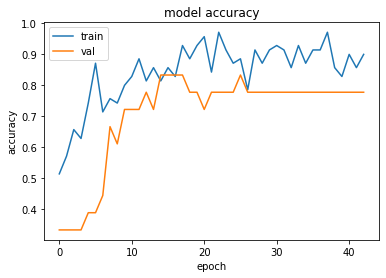

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

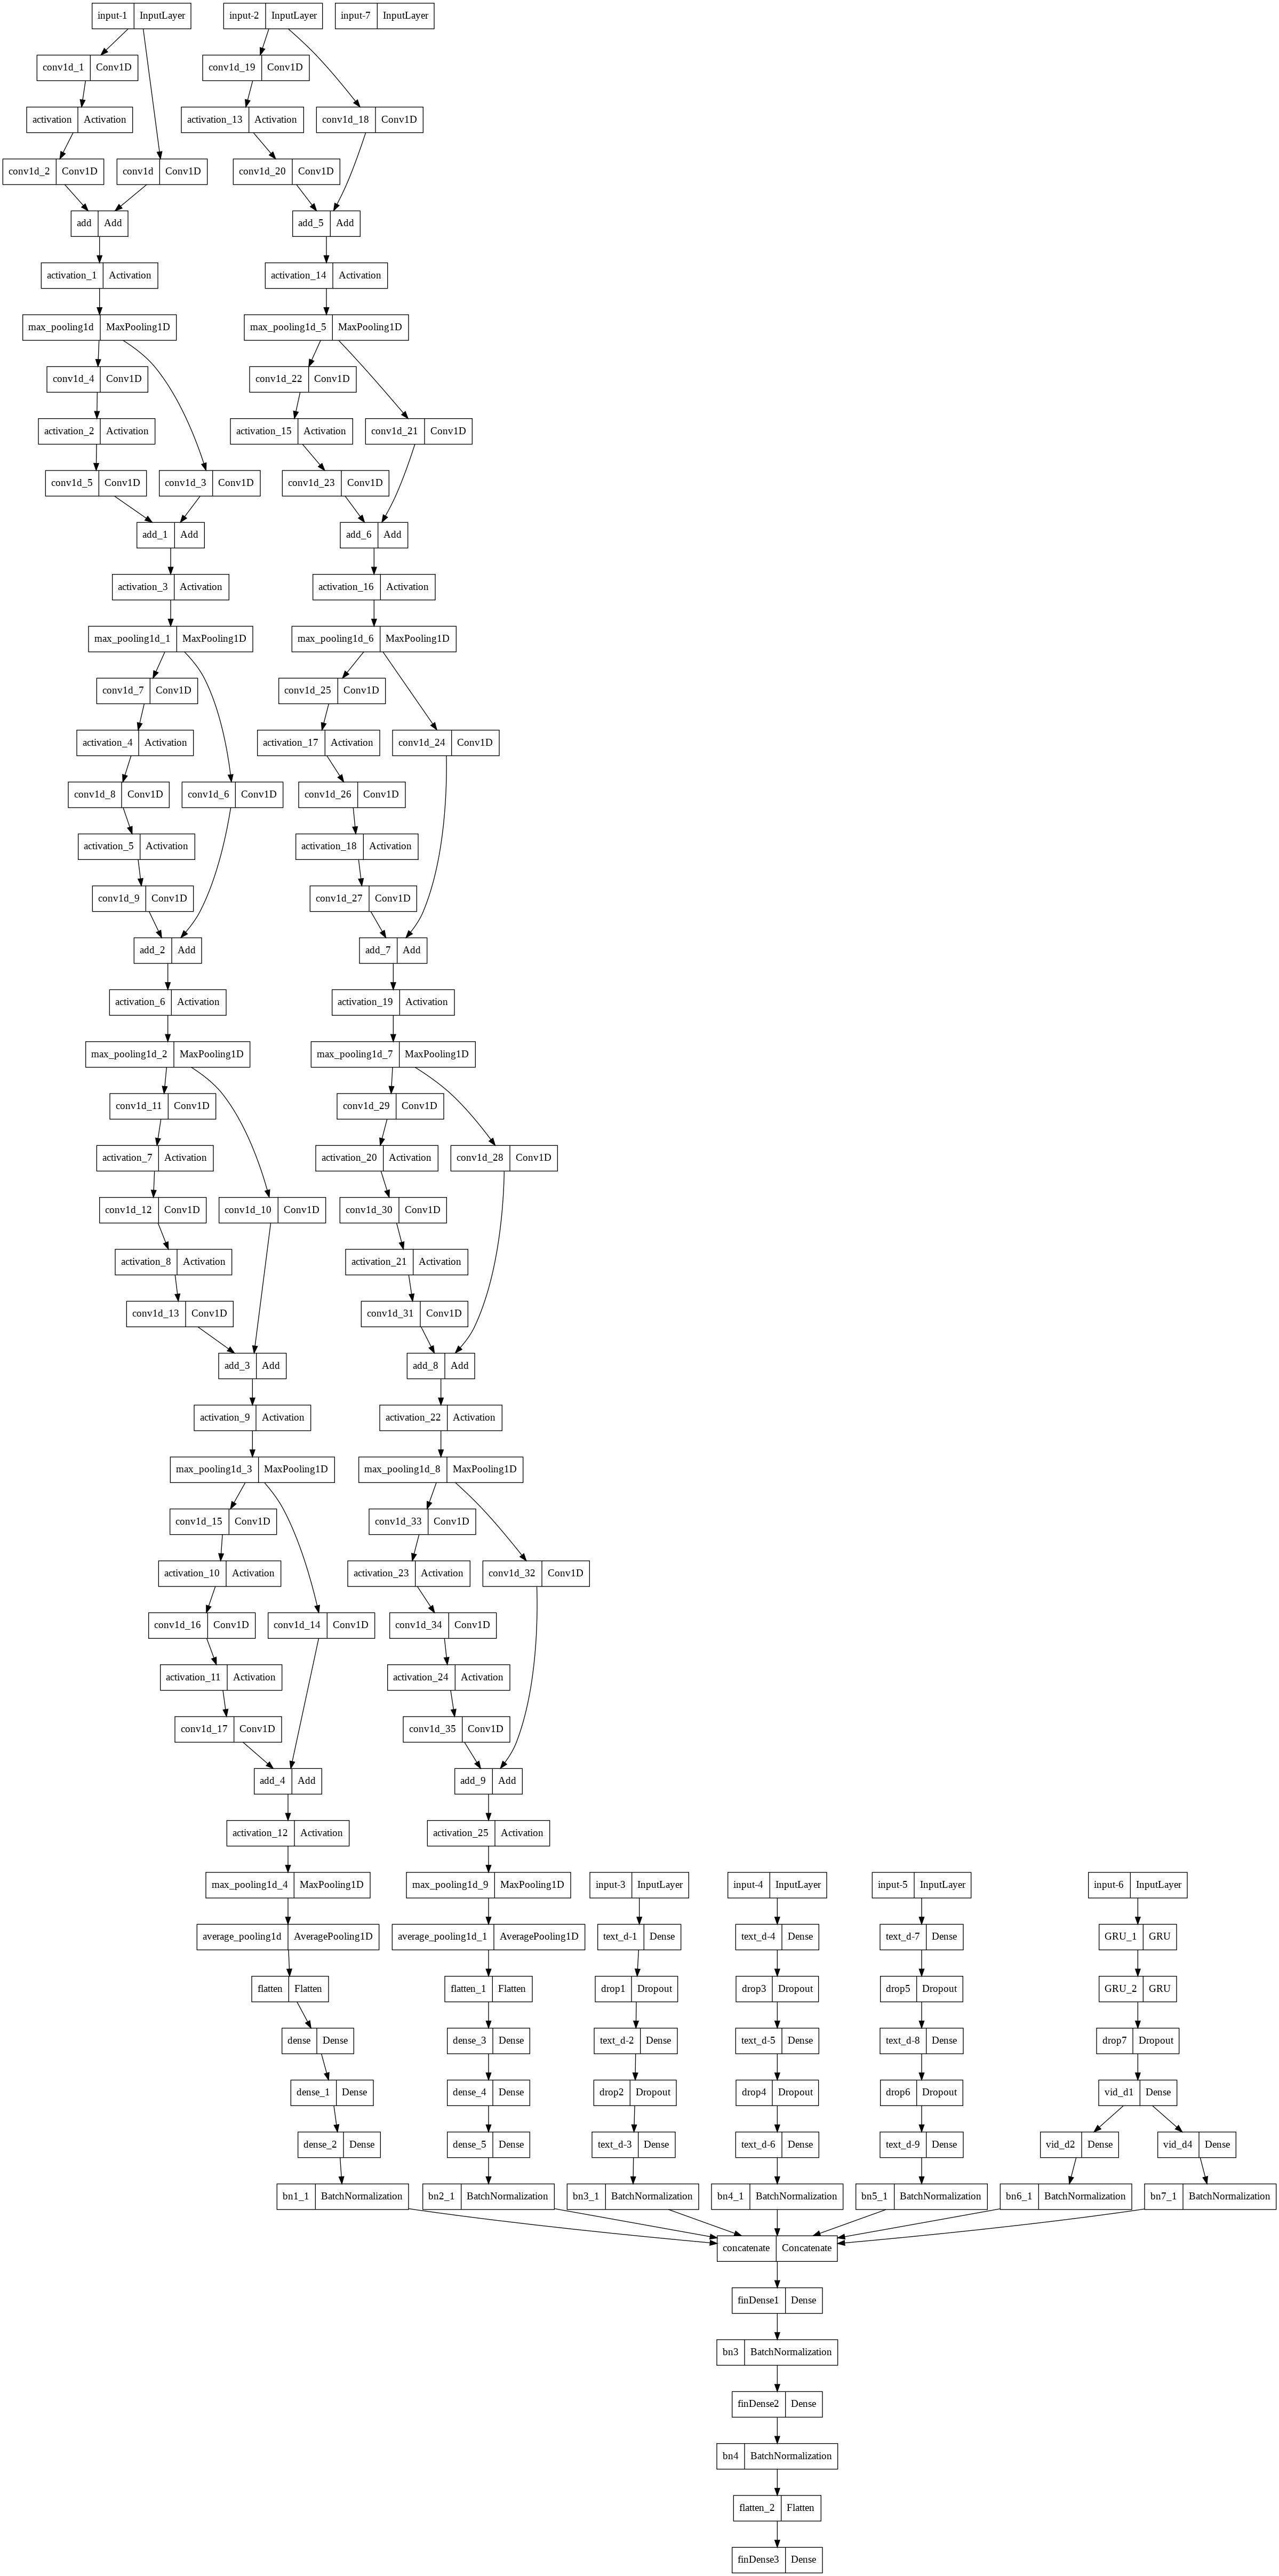

In [41]:
tf.keras.utils.plot_model(model,to_file="Aud_Text_Model.png", show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir="TB", expand_nested=False,
    dpi=96, layer_range=None, show_layer_activations=False)

In [42]:
save_path = '/content/drive/MyDrive/Mini Project/'
model.save(save_path)